<a href="https://colab.research.google.com/github/santos-luciano/GTDL/blob/main/An%C3%A1lise_do_tempo_de_recupera%C3%A7%C3%A3o_do_IBOVESPA_de_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance
!pip install lifelines

In [3]:
import pandas as pd
import yfinance as yf
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
from lifelines.plotting import plot_lifetimes

Em março de 2020, a B3 (bolsa de valores oficial do Brasil), acionou o seu mecanismo de defesa um total de 6 vezes, o *circuit breaker*. Essa ferramente é acionada em momentos de bastante variação do índice, comportamento comum em crises. A crise atrelada a este momento, se diz respeito ao aumento do número de casos de covid no mundo.

# Analisando o IBOVESPA no ano 2020

In [6]:
ibovespa = yf.download('^BVSP',start = '2020-01-01',end = '2020-12-31')['Close']

[*********************100%***********************]  1 of 1 completed


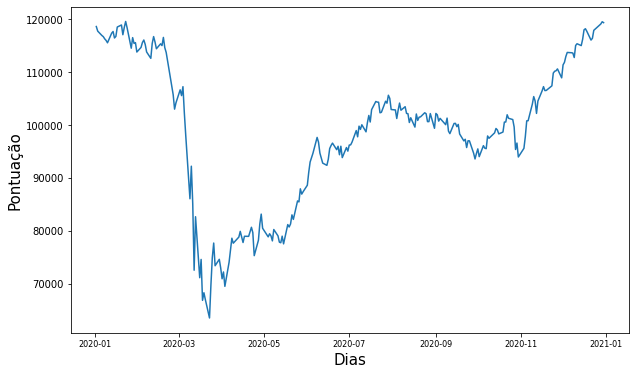

In [7]:
plt.figure(figsize = (10,6))
plt.plot(ibovespa)
plt.xlabel('Dias',fontsize = 15)
plt.ylabel('Pontuação',fontsize = 15)
plt.xticks(fontsize = 8)
plt.show()

Na figura acima, é possível observar a evolução do IBOVESPA ao longo de 2020. O índice tem uma queda acentuada no mês de março até chegar o sua pontuação mínima no ano, para assim iniciar sua recuperação.

In [8]:
variacao = [0]
for dia in range(1,len(ibovespa)):
  variacao.append(ibovespa[dia]/ibovespa[dia-1]-1)
ibovespa_variacao = pd.DataFrame(variacao,columns = ['var'])
ibovespa_variacao.index = ibovespa.index

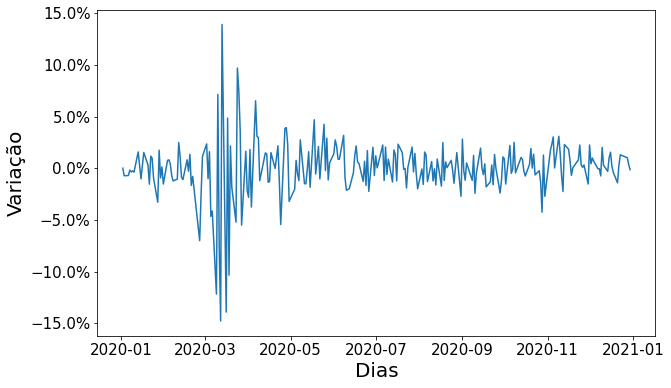

In [9]:
plt.figure(figsize = (10,6))
plt.plot(ibovespa_variacao['var'])
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.xlabel('Dias',fontsize = 20)
plt.ylabel('Variação',fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

Na Figura acima é mostrada a variação diária do IBOVESPA no ano de 2020, é possível observar que atingiu variações acima de 10%

Na seção abaixo, será explorado o comportamento das ações que integravam o índice no momento da crise

# Leitura do arquivo com as ações que integravam o IBOVESPA no 1º quadrimestre de 2020

O primeiro acionamento do *circuit breaker* aconteceu no dia 9 de março (segunda-feira), ou seja, foi observado uma variação de +10% na pontuação comporada com o último dia de negociação que foi 6 de março (sexta-feira).

Será analisada o tempo de recuperação das ações com o marco inicial o último dia antes do acionamento do mecanismo de defesa, o dia 06 de março de 2020.

In [ ]:
acoes_ibovespa = pd.read_excel('/content/drive/MyDrive/PRV_GMCT.XLSX',skiprows=1 ).iloc[:73]
cod_acoes = acoes_ibovespa['COD.'].values+'.SA'
cotacoes_acoes = yf.download(cod_acoes.tolist(),start = '2020-03-06',end = '2020-12-31')['Close']

In [14]:
cotacoes_acoes_ibo = cotacoes_acoes.reset_index()
#cotacoes_acoes_ibo.reset_index(inplace = True)
primeira_recuperacao = []
falha = []
for cod in cod_acoes.tolist():
  col_acao = cotacoes_acoes_ibo[cod]
  if col_acao.isnull().sum()!=204:
    recuperacoes = col_acao[col_acao>=col_acao[0]]
    try:
      primeira_recuperacao.append(recuperacoes.index[1])
      falha.append(1)
    except:
      primeira_recuperacao.append(203)
      falha.append(0)
  else:
    primeira_recuperacao.append(None)
    falha.append(None)

In [15]:
dados_sobrevivencia = pd.DataFrame([acoes_ibovespa['COD.'].values,primeira_recuperacao,falha],index = ['cod_acoes','dias','falha']).T
dados_sobrevivencia = dados_sobrevivencia.set_index('cod_acoes')
dados_sobrevivencia_completo = dados_sobrevivencia.dropna(subset = ['dias'])

/usr/local/lib/python3.8/dist-packages/lifelines/plotting.py:727: UserWarning: For less visual clutter, you may want to subsample to less than 25 individuals.
  warnings.warn("For less visual clutter, you may want to subsample to less than 25 individuals.")


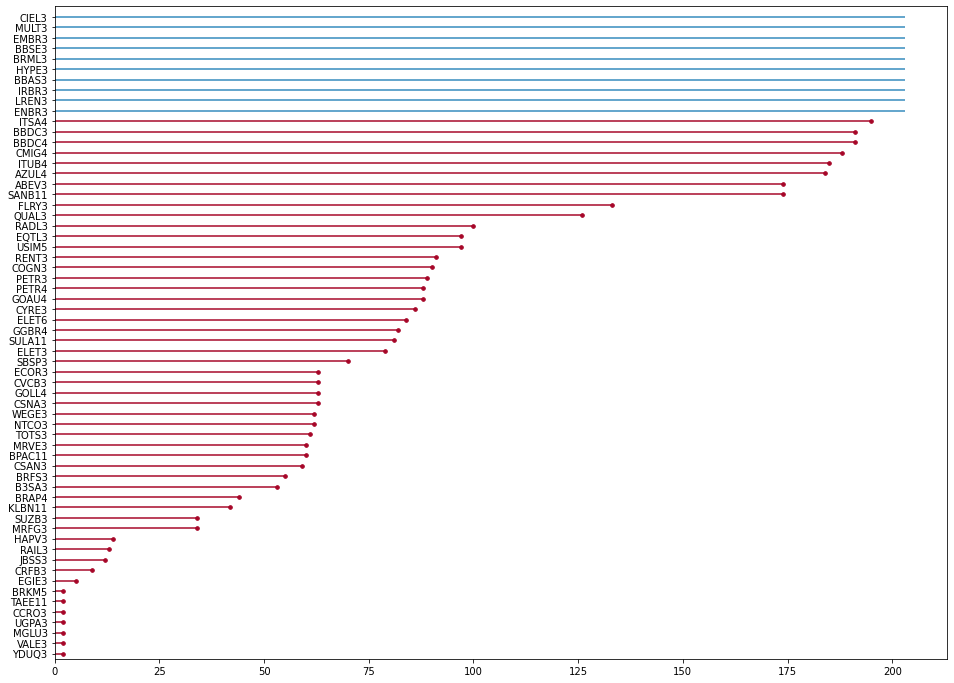

In [16]:
plt.figure(figsize = (16,12))
ax = plot_lifetimes(dados_sobrevivencia_completo.dias,dados_sobrevivencia_completo.falha)

A figura acima mostra quantos dias de negociações na B3, foram necessários para a ação retomar a cotação do dia 06 de março de 2020. As ações com linha da cor azul, são ações que não conseguiram atingir a sua 1ª recuperação no ano de 2020.

#Estimando a curva de sobrevivência para o IBOVESPA

In [17]:
from lifelines import(KaplanMeierFitter,WeibullFitter,ExponentialFitter,LogNormalFitter
                       ,PiecewiseExponentialFitter)

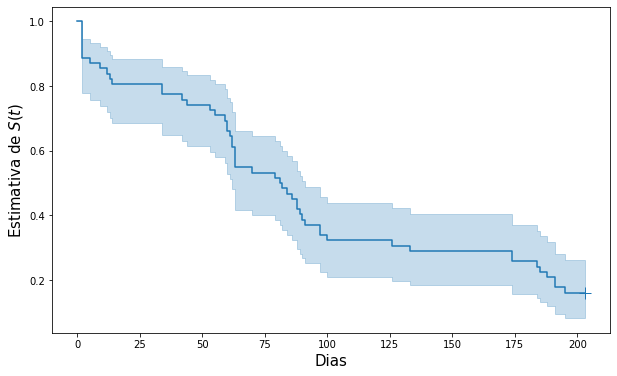

In [21]:
kmf = KaplanMeierFitter()
T = dados_sobrevivencia_completo["dias"]
E = dados_sobrevivencia_completo["falha"]

#kaplan meier
plt.figure(figsize = (10,6))
kmf.fit(T, event_observed=E)
kmf.plot_survival_function(show_censors = True,ci_show=True,legend = False)
plt.xlabel('Dias',fontsize = 15)
plt.ylabel('Estimativa de $S(t)$',fontsize = 15)
plt.show()

Cada degrau da Figura representa que uma ação atingiu a sua 1ª recuperação

In [23]:
print(kmf.median_survival_time_)

81.0


A mediana é de 81 dias, ou seja, 50% das ações conseguiram atingir a sua 1ª recuperação em até 81 dias de negociações na B3

Na busca de encontrar um modelo descreva da melhor forma o tempo da 1ª recuperação da ações que integravam o IBOVESPA no 1º quadrimestre de 2020, será estimado a $S(t)$ dos principais modelos paramétricos

In [24]:
# modelos parametricos

wbf = WeibullFitter()
exf = ExponentialFitter()
lnf = LogNormalFitter()

/usr/local/lib/python3.8/dist-packages/lifelines/utils/__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/usr/local/lib/python3.8/dist-packages/lifelines/utils/__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/usr/local/lib/python3.8/dist-packages/lifelines/utils/__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


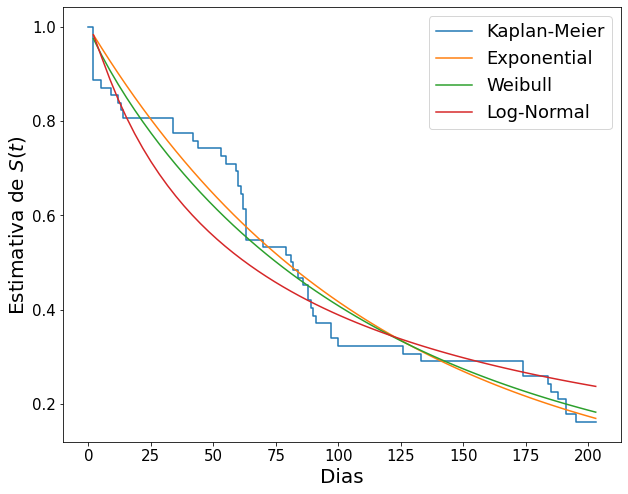

In [26]:
plt.figure(figsize = (10,8))
kmf.fit(T, event_observed=E, label="Kaplan-Meier")
kmf.plot_survival_function(show_censors = False,ci_show=False)

exf.fit(T, event_observed=E, label="Exponential")
exf.plot_survival_function(show_censors = False,ci_show = False)

wbf.fit(T, event_observed=E, label="Weibull")
wbf.plot_survival_function(show_censors = False,ci_show = False)

lnf.fit(T, event_observed=E, label="Log-Normal")
lnf.plot_survival_function(show_censors = False,ci_show = False)

plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Dias',fontsize = 20)
plt.ylabel('Estimativa de $S(t)$',fontsize = 20)
plt.legend(fontsize = 18)
plt.show()